In [9]:
#reference
#https://scikit-learn.org/stable/
#https://xgboost.readthedocs.io/en/latest/python/python_intro.html
#https://pypi.org/project/PrettyTable/

In this notebook we will find the best model which can perform good on our dataset,

But we have used dataset which includes Histogram bin's columns during EDA & Feature selection so that we can use best columns from histogram bin's columns 

In [10]:
import tqdm
import numpy as np
import pandas as pd
import imblearn
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

sns.set_style(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
#We have use this fuction to print the confusion, Precision and Recall matrix 
#reference: https://colab.research.google.com/drive/1YQoysuPgCDJ_HyOuclAYMVd04JNAjzP6

def plot_confusion_matrix(test_y, predict_y):
    #Confusion matrix
    C = confusion_matrix(test_y, predict_y)
    
    #precision matrix 
    A =(((C.T)/(C.sum(axis=1))).T)
    
    #recall matrix 
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")

    #Heatmap of Confusion matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    #Heatmap of Presicion matrix
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    #Heatmap of Recall matrix 
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [13]:
#Data Loading
data = pd.read_csv(r'/content/drive/My Drive/Case-Study 2 /Datasets/histo_final_data.csv')
data.head()

,target,sensor1_measure,sensor8_measure,sensor14_measure,sensor15_measure,sensor16_measure,sensor17_measure,sensor24_histogram_bin8,sensor26_histogram_bin5,sensor26_histogram_bin6,sensor27_measure,sensor32_measure,sensor33_measure,sensor34_measure,sensor35_measure,sensor45_measure,sensor46_measure,sensor47_measure,sensor48_measure,sensor49_measure,sensor53_measure,sensor55_measure,sensor60_measure,sensor64_histogram_bin3,sensor66_measure,sensor69_histogram_bin3,sensor88_measure,sensor104_measure,sensor105_histogram_bin4,sensor105_histogram_bin5
0,0.0,14.0,2192.0,14008.0,11974.0,8700.0,364.0,7418.0,14.0,54.0,23076.0,2192.0,198.0,6200.0,2464.0,13.92,23076.0,23076.0,24912.0,41.0,7418.0,292.0,0.0,2104.0,12.0,20.0,0.0,52.0,0.0,0.0
1,0.0,54466.0,1626796.0,3062844.0,2682152.0,421542.0,318898.0,203802.0,172636.0,637734.0,3484966.0,1626796.0,46450.0,222158.0,198672.0,54465.89,3484966.0,3484966.0,3488888.0,18659.0,3366152.0,133996.0,0.0,8576.0,234.0,328538.0,0.0,1440.0,380372.0,251520.0
2,0.0,38954.0,1167684.0,2295368.0,1967476.0,420864.0,288288.0,671486.0,149082.0,241884.0,2717392.0,1167684.0,34882.0,218490.0,199402.0,38953.31,2717392.0,2717392.0,2722870.0,18123.0,2601654.0,75694.0,0.0,389296.0,12.0,134580.0,0.0,968.0,304266.0,262662.0
3,0.0,52290.0,1533086.0,3060288.0,2660996.0,527984.0,349392.0,338938.0,190880.0,169308.0,3588932.0,1533086.0,44388.0,298230.0,228548.0,52290.33,3588932.0,3588932.0,3604268.0,23012.0,3442626.0,100606.0,0.0,224694.0,6.0,240336.0,0.0,1442.0,477404.0,374130.0
4,0.0,1710.0,41982.0,87910.0,79684.0,15514.0,5830.0,44894.0,4904.0,2146.0,103450.0,41982.0,942.0,9590.0,5902.0,1709.91,103450.0,103450.0,141490.0,659.0,123790.0,2252.0,0.0,13534.0,8.0,2518.0,0.0,80.0,5318.0,59226.0


In [14]:
#Data Preprocessing and Train-Test split

X = data.iloc[:, 1:].values
y = np.array(list(map(int, data.iloc[:, 0].values))).reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.15)
X_train, X_cv, y_train, y_cv = train_test_split(X_train,y_train, test_size=0.15)

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_cv = scaler.transform(X_cv)
X_test = scaler.transform(X_test)

X_train.shape, y_train.shape, X_cv.shape, y_cv.shape,X_test.shape, y_test.shape

((22491, 29), (22491, 1), (3970, 29), (3970, 1), (4670, 29), (4670, 1))

##Search for Best Model:-

##Metric: F1-Score(Micro):
so to select best model we will use F1 score (micro) because 'micros' Calculate metrics globally by counting the total true positives, false negatives and false positives, 
  and for our problem false positives and false positives matters alot so instead of taking simple f1-score, we choose this as KPI matric for our problm

here we will train 6 different models and will find best hyperparameters by train and testing the model on cv set using Linear Search , And then we will train these model using that tuned hyperparameter and after these trained model we will calculate the micro F1-score of test data and then we will compare the best result and select the best model which will give the highest micro F1-score on Test data 

##Models that we are going to train for this Experiments:
##1) Random (For findng the worst case)
##2) Logistic Regression
##3) KNN
##4) SVM(Linear)
##5) SVM(RBF)
##6) Decision Tree Classifier
##7) Random-Forest (ensemble)
##8) Gradient Boosting (Boosting)

In [15]:
final_score = dict()

##Random Model:

Test f1-Score:  0.5055674518201285


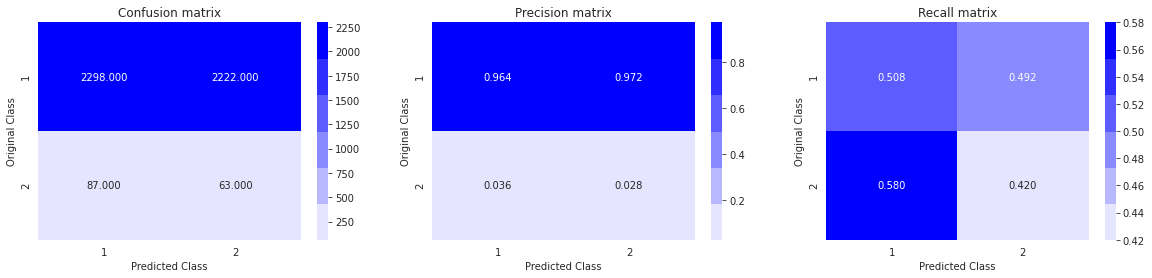

In [16]:
pred_y = [np.random.randint(2) for i in range(len(X_test))]

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['Random'] = test_f1
print("Test f1-Score: ", test_f1)
plot_confusion_matrix(y_test, pred_y)

it shows some random results, so that we can use this f1 score as minimum or base score 

##Logistic Regression:

best alpha =  0.001 Test-f1-score =  0.9751605995717345


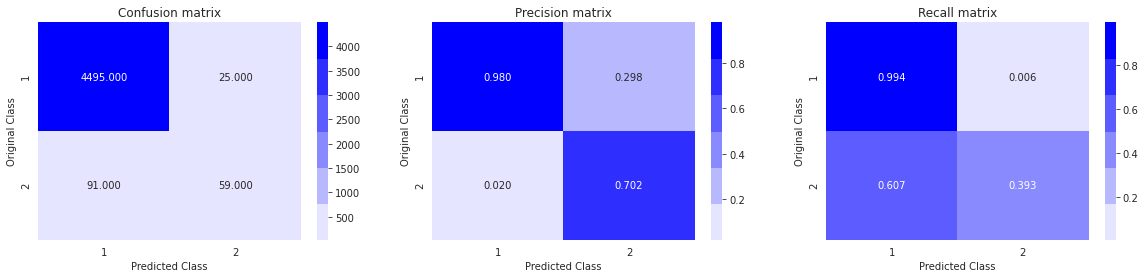

In [17]:
# Hyperparameter tuning

alpha = [10 ** x for x in range(-5, 2)]
score = []
for i in alpha:
  model = SGDClassifier(loss='log', alpha=i, penalty='l2')
  model.fit(X_train, y_train)
  pred_y = model.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter 
best_alpha = alpha[np.argmax(score)]
model = SGDClassifier(loss='log', alpha=alpha[np.argmax(score)], penalty='l2')
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['Logistic-Regression'] = test_f1
print("best alpha = ",best_alpha,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

#KNN:

best K =  1 Test-f1-score =  0.9773019271948609


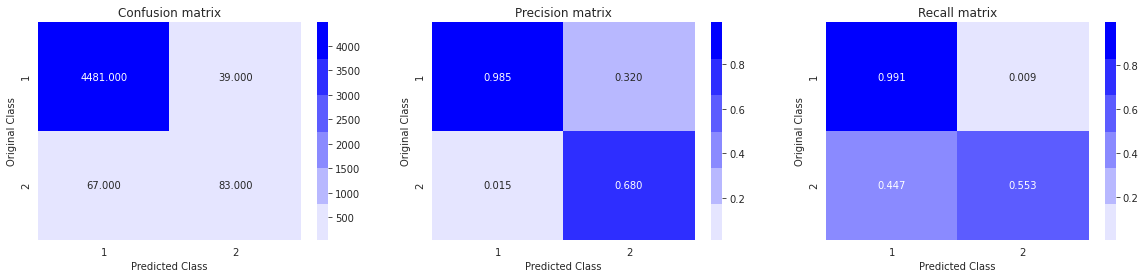

In [18]:
# Hyperparameter tuning

K = np.arange(1, 100, 4).tolist()
score = []
for k in K:
  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, y_train)
  pred_y = model.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter
best_k = K[np.argmax(score)]
model = KNeighborsClassifier(n_neighbors=k)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['KNN'] = test_f1
print("best K = ",best_k,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

##SVM (Linear):

best alpha =  10 Test-f1-score =  0.9811563169164882


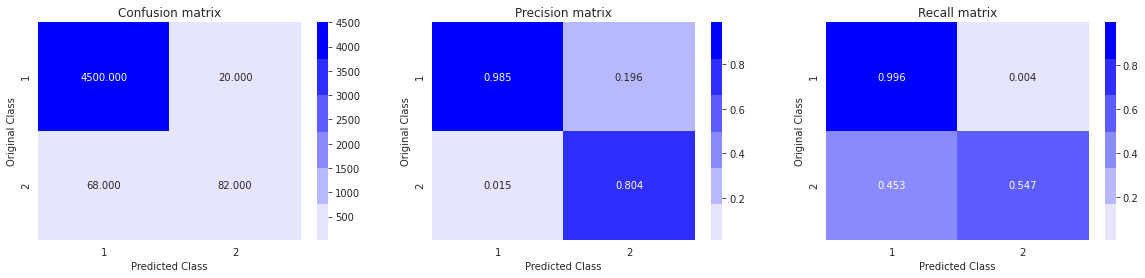

In [19]:
# Hyperparameter tuning

alpha = [10 ** x for x in range(-5, 2)]
score = []
for i in alpha:

  model = SVC(C=i, kernel='linear')
  model.fit(X_train, y_train)
  pred_y = model.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter
best_alpha = alpha[np.argmax(score)]
model = SVC(C=best_alpha, kernel='linear')
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['Linear-SVM'] = test_f1
print("best alpha = ",best_alpha,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

##SVM (RBF):

best alpha =  10 Test-f1-score =  0.9839400428265525


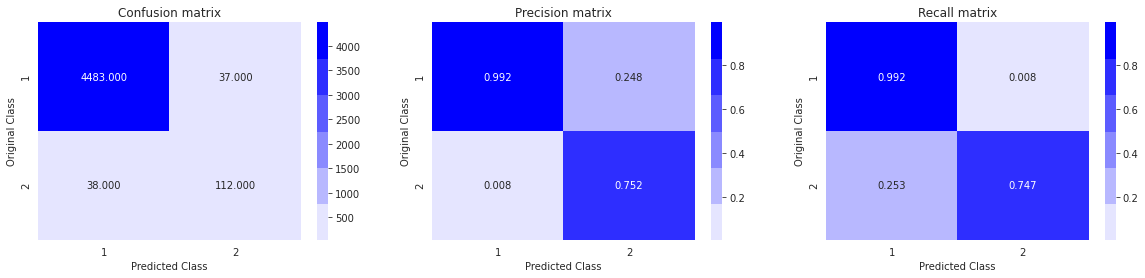

In [20]:
# Hyperparameter tuning

alpha = [10 ** x for x in range(-5, 2)]
score = []
for i in alpha:

  model = SVC(C=i)
  model.fit(X_train, y_train)
  pred_y = model.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter
best_alpha = alpha[np.argmax(score)]
model = SVC(C=best_alpha)
model.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['RBF-SVM'] = test_f1
print("best alpha = ",best_alpha,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

#Decision Tree:

best Depth =  10 Test-f1-score =  0.9792291220556745


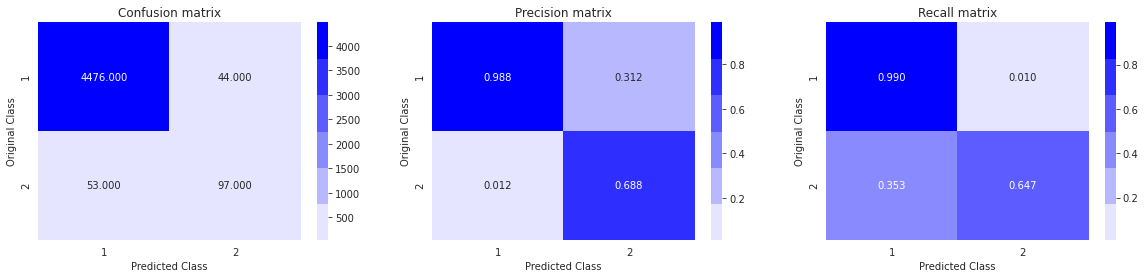

In [21]:
# Hyperparameter tuning

Depth = [5, 10, 50, 100, 200, 500]
score = []
for d in Depth:

  dt = DecisionTreeClassifier(max_depth=d)
  dt.fit(X_train, y_train)
  pred_y = dt.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter
best_d = Depth[np.argmax(score)]
dt = DecisionTreeClassifier(max_depth=best_d)
dt.fit(X_train, y_train)
pred_y = dt.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['Decision-Tree'] = test_f1
print("best Depth = ",best_d,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

##Random Forest:

best Depth =  200 Test-f1-score =  0.9865096359743041


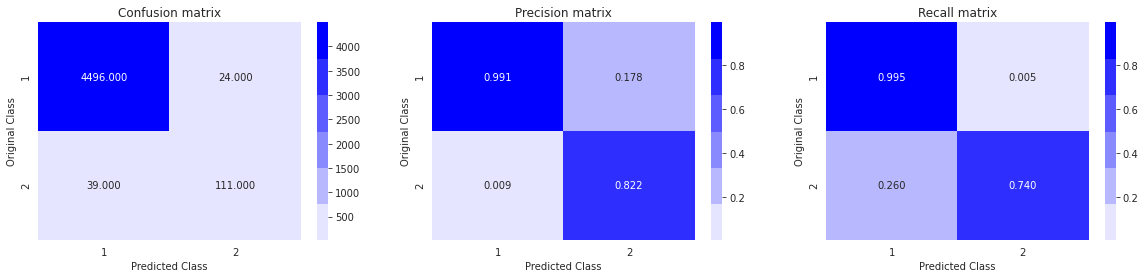

In [22]:
# Hyperparameter tuning

estimators = [5, 10, 50, 100, 200, 500]
score = []
for e in estimators:

  rf = RandomForestClassifier(n_estimators=e, max_depth=100)
  rf.fit(X_train, y_train)
  pred_y = rf.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter
best_e = estimators[np.argmax(score)]
rf = RandomForestClassifier(n_estimators=best_e, max_depth=100)
rf.fit(X_train, y_train)
pred_y = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['Random-Forest'] = test_f1
print("best Depth = ",best_e,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

#Gradient-Boosting:

best Depth =  500 Test-f1-score =  0.9854389721627409


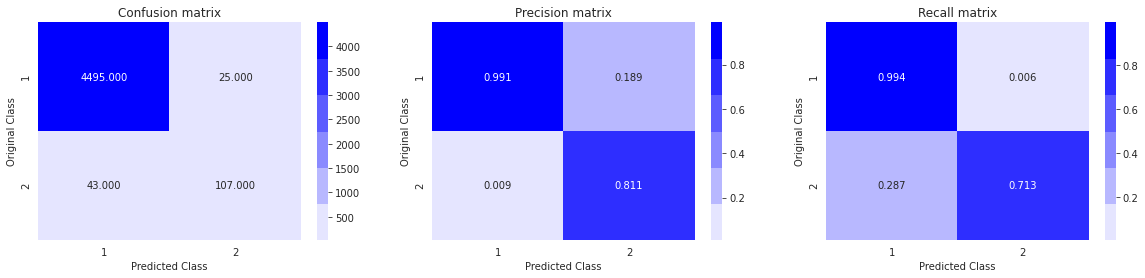

In [23]:
# Hyperparameter tuning

estimators = [5, 10, 50, 100, 200, 500]
score = []
for e in estimators:

  gb = XGBClassifier(n_estimators=e)
  gb.fit(X_train, y_train)
  pred_y = gb.predict(X_cv)
  score.append((f1_score(y_cv, pred_y,average='micro')))

#Training the model with the best hyperparameter
best_e = estimators[np.argmax(score)]
gb = XGBClassifier(n_estimators=best_e)
gb.fit(X_train, y_train)
gb = model.predict(X_test)

test_f1 = f1_score(y_test, pred_y,average='micro')
final_score['Gradient-Boosting'] = test_f1
print("best Depth = ",best_e,"Test-f1-score = ", test_f1)
plot_confusion_matrix(y_test, pred_y)

In [29]:
#Results

final_score = dict(sorted(dict(final_score).items(), key = lambda kv:(kv[1], kv[0])))
from prettytable import PrettyTable
    
x = PrettyTable()
x.field_names = ["No", "Model", "micro F1-Score"]
for idx, (model, f1) in enumerate(final_score.items()):
  x.add_row([idx+1, model, f1])
print(x)

+----+---------------------+--------------------+
| No |        Model        |   micro F1-Score   |
+----+---------------------+--------------------+
| 1  |        Random       | 0.5055674518201285 |
| 2  | Logistic-Regression | 0.9751605995717345 |
| 3  |         KNN         | 0.9773019271948609 |
| 4  |    Decision-Tree    | 0.9792291220556745 |
| 5  |      Linear-SVM     | 0.9811563169164882 |
| 6  |       RBF-SVM       | 0.9839400428265525 |
| 7  |  Gradient-Boosting  | 0.9854389721627409 |
| 8  |    Random-Forest    | 0.9865096359743041 |
+----+---------------------+--------------------+


  So, after complition of the various Machine Learning model's training. we can conlude that the Random-Forest is best model among the other models which has achieved micro F1-Score = 0.9854 on Test Data after Tuning with the "n_estimator" hyperparameter on cross-validation set

In [32]:
# Saving the Best model  
import pickle

pkl_filename = "/content/drive/My Drive/Case-Study 2 /Model/model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(rf, file)

##Final Comparison:

In [31]:
previous_results = [0.5077410930796493,0.9759373251259094,0.9781757134862898 ,0.978735310576385,0.9791083753031152,0.9807871665734005,0.9824659578436858,0.983025554933781]

x = PrettyTable()
x.field_names = ["No", "Model", "micro F1-Score (without Histogram columns)", "micro F1-Score (with Histogram columns)"]
for idx, (model, f1) in enumerate(final_score.items()):
  x.add_row([idx+1, model, previous_results[idx],f1])
print(x)

+----+---------------------+--------------------------------------------+-----------------------------------------+
| No |        Model        | micro F1-Score (without Histogram columns) | micro F1-Score (with Histogram columns) |
+----+---------------------+--------------------------------------------+-----------------------------------------+
| 1  |        Random       |             0.5077410930796493             |            0.5055674518201285           |
| 2  | Logistic-Regression |             0.9759373251259094             |            0.9751605995717345           |
| 3  |         KNN         |             0.9781757134862898             |            0.9773019271948609           |
| 4  |    Decision-Tree    |             0.978735310576385              |            0.9792291220556745           |
| 5  |      Linear-SVM     |             0.9791083753031152             |            0.9811563169164882           |
| 6  |       RBF-SVM       |             0.9807871665734005             

##Final Conclusion:-

  So after training the models with both kind of datasets 1) only measure columns 2) measure + histogram bin's columns , we have printed the results in the above table ,
  By looking at that table we made decision to finalize the Random-Forest model with max_depth of '200' ,which we have trained on dataset which has both kind of feature (measure + histogram bin) 
  beacuse these combination of dataset + model + hyperparameter has performed best and it has shown the very less amount of false positives in it's confusion matrix and resulted the micro f1-score = '0.9854'. which is highest as compare to rest of combination.
  